## Tensorflow GPU environment on Google Colab

In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass
  


In [2]:
!pip install pydicom

     |████████████████████████████████| 35.5MB 99kB/s 


## Import Libraries

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import pydicom as dicom
import json
import cv2
import h5py
import glob 
from tqdm import tqdm
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from skimage.measure import label, regionprops, regionprops_table

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
os.chdir('/content/drive/My Drive/')

## Read JSON file containing data 

In [6]:
# Read JSON

with open ('data.json','r') as read_file:
    JasonData = json.load(read_file)

In [7]:
# Convert into numpy array
JasonData_list = np.array(list(JasonData.items()))
print(len(JasonData_list))
JasonData_list[:1]

26684


array([['0004cfab-14fd-4e49-80ba-63a80b6bddd6',
        {'dicom': 'stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm', 'label': 0, 'boxes': []}]],
      dtype=object)

## Split Data into Train, Test and Validation

In [8]:
data = JasonData_list[:26684]
random.shuffle(data)
train_val = data[:23286]
X_test = data[23286:]
X_train = train_val[:16300]
X_val=train_val[16300:]
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(16300, 2)
(6986, 2)
(3398, 2)


## Set Model Parameters

In [9]:
#Image size for model input
IMAGE_WIDTH=128
IMAGE_HEIGHT=128

#original image dimensions
imageWidth=1024
imageHeight=1024

ALPHA = 1
EPOCHS = 10
BATCH_SIZE=24

## Create Data Generator 

In [ ]:
class DataGenerator(Sequence):
    
    def __init__(self, dataset, batch_size=24, shuffle=True, predict=False):        
        self.dataset = dataset
        self.batch_size=batch_size
        self.shuffle=shuffle
        self.predict=predict
        self.on_epoch_end()
    
    def __len__(self):         
        return math.ceil(len(self.dataset)/self.batch_size)    
       
    def __getitem__(self, index):   
        
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        image_batch = [self.dataset[i][1]['dicom'] for i in indexes]
        bbox_batch = [self.dataset[i][1]['boxes'] for i in indexes]
        
        X = self.__generate_X(image_batch)
        if self.predict:
            return X
        else:
            masks = self.__generate_masks(bbox_batch)
            return X, masks
        
    def __generate_X(self, image_batch): 
        
        X = np.zeros((len(image_batch), IMAGE_WIDTH, IMAGE_HEIGHT,3), dtype=np.float32)
        for k, image_path in enumerate(image_batch):
            img = dicom.read_file(image_path).pixel_array
            img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
            img = np.stack((img,)*3, axis=-1)
            X[k] = preprocess_input(np.array(img, dtype=np.float32))
        return X
                
    def __generate_masks(self, bbox_batch):        
        
        masks = np.zeros((len(bbox_batch), IMAGE_WIDTH, IMAGE_HEIGHT))
        width_factor = IMAGE_WIDTH/imageWidth
        height_factor = IMAGE_HEIGHT/imageHeight
        
        for k, bbox_items in enumerate(bbox_batch):
            if len(bbox_items) > 0:
                for idx, val in enumerate(bbox_items):
                    x1 = round(val[0]* width_factor)
                    x2 = round((val[0]+val[2])* width_factor)
                    y1 = round(val[1]*height_factor)  
                    y2 = round((val[1]+val[3])*height_factor)
                    masks[k][y1:y2, x1:x2]=1                    
            else:
                masks[k][:,:]=0                
        return masks
                   
    def on_epoch_end(self):  
        self.indexes = np.arange(len(self.dataset))      
        if self.shuffle == True:
            np.random.shuffle(self.indexes) 
     

## Create Model

In [11]:
def create_model(trainable=True):
    
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights=None)
    model.load_weights('mobilenet_1_0_128_tf_no_top.h5')
    
    for layer in model.layers:
        layer.trainable = trainable
        
    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output
    
    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = UpSampling2D()(x)
    
    x = Conv2D(1, kernel_size=1, activation='sigmoid')(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    
    return Model(inputs=model.input, outputs=x)

## Define Loss and Dice coefficient

In [12]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - log(dice_coefficient(y_true, y_pred) + epsilon())

In [13]:
def dice_coefficient(y_true, y_pred):
    
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

## Compile and fit the model 

In [14]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():

  model = create_model()
  model.summary()

  optimizer = Adam(lr = 0.001)
  model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

  checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", period=1)
  stop = EarlyStopping(monitor="val_loss", patience=10, mode="min")
  reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr=1e-6, verbose=1, mode="min")
  

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

In [15]:
train_gen = DataGenerator(X_train, batch_size=24, shuffle=True, predict=False)
val_gen= DataGenerator(X_val, batch_size=24, shuffle=False, predict=False)

In [18]:
history=model.fit_generator(train_gen, validation_data=val_gen,
                    callbacks = [checkpoint, reduce_lr, stop], 
                    verbose=1, epochs=30, use_multiprocessing=False, workers=8)


Epoch 1/30
680/680 [==============================] - ETA: 0s - dice_coefficient: 0.4351 - loss: 1.0798
Epoch 00001: val_loss improved from inf to 1.16248, saving model to model-1.08.h5
680/680 [==============================] - 951s 1s/step - dice_coefficient: 0.4351 - loss: 1.0798 - val_dice_coefficient: 0.4285 - val_loss: 1.1625 - lr: 0.0010
Epoch 2/30
680/680 [==============================] - ETA: 0s - dice_coefficient: 0.5107 - loss: 0.8682
Epoch 00002: val_loss improved from 1.16248 to 1.01364, saving model to model-0.87.h5
680/680 [==============================] - 212s 311ms/step - dice_coefficient: 0.5107 - loss: 0.8682 - val_dice_coefficient: 0.4629 - val_loss: 1.0136 - lr: 0.0010
Epoch 3/30
680/680 [==============================] - ETA: 0s - dice_coefficient: 0.5534 - loss: 0.7675
Epoch 00003: val_loss did not improve from 1.01364
680/680 [==============================] - 214s 314ms/step - dice_coefficient: 0.5534 - loss: 0.7675 - val_dice_coefficient: 0.4688 - val_loss: 

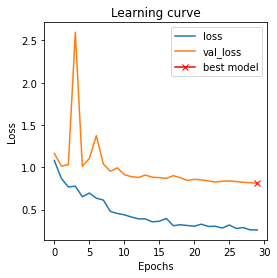

In [19]:
plt.figure(figsize=(4, 4))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();


## Model Evaluation on Validation set

In [20]:
model = create_model()
model.load_weights('model-0.26.h5')
optimizer = Adam(lr=0.001)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [21]:
model.evaluate_generator(val_gen, verbose=1, workers=8)

Instructions for updating:
Please use Model.evaluate, which supports generators.
292/292 [==============================] - 54s 187ms/step - loss: 0.8118 - dice_coefficient: 0.5579


[0.8117769360542297, 0.5578545331954956]

## Evaluating the Test set

In [22]:
test_masks = np.zeros((int(len(X_test)), IMAGE_HEIGHT, IMAGE_WIDTH), dtype=np.float32)
test_img = np.zeros((int(len(X_test)), IMAGE_HEIGHT, IMAGE_WIDTH,3), dtype=np.float32)

In [23]:
for index in tqdm(range(len(X_test))):
    img = dicom.read_file(X_test[index][1]['dicom']).pixel_array
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    img = np.stack((img,)*3, axis=-1)            
    test_img[index]=preprocess_input(np.array(img, dtype=np.float32))
    
    for i in X_test[index][1]['boxes']:
      x1 = round(i[0]*IMAGE_WIDTH/imageWidth)
      x2 = round((i[0]+i[2])*IMAGE_WIDTH/imageWidth)
      y1 = round(i[1]*IMAGE_HEIGHT/imageHeight)         
      y2 = round((i[1]+i[3])*IMAGE_HEIGHT/imageHeight)
      test_masks[index][y1:y2, x1:x2]=1

100%|██████████| 3398/3398 [18:28<00:00,  3.07it/s]


## Performance Matrix 

In [24]:
per_mat = pd.DataFrame(columns=['Minimum_Confidence','True Positive','True Negative','False Positive','False Negative','Accuracy','Recall','Precision','F1-score','Specificity'])

In [25]:
def find_bbox(regions):
  MIN_AREA=100
  boxes = []
  for props in regions:    
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    
    if props.area > MIN_AREA:
        x = props.bbox[1]
        y = props.bbox[2]
        w = props.bbox[1]+props.bbox[3]
        h = props.bbox[0]+props.bbox[2]
        boxes.append([x,y,w,h]) 
  return boxes

In [26]:
def performace_matrix(test_data = X_test,test = test_img,per_mat = per_mat):

 """
 Checks if the model is correctly classifying the patient as pneumonia or non-pneumonia
 
 """

  lt = [0.5,.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.92,0.94,0.95,0.955,0.96,0.965,0.97,0.975,0.98,0.983,0.985,0.987,0.99]
  for j in range(len(lt)):
    TN = 0
    TP = 0
    FP = 0
    FN = 0
    threshold = lt[j]
    for i in range(len(test_data)):
      pred_mask = model.predict(test_img[i].reshape(1,128,128,3))
      pred_mask = pred_mask.reshape(128,128)
      pred_mask_t = pred_mask > threshold
      label_img = label(pred_mask_t)
      regions = regionprops(label_img)
      boxes = find_bbox(regions)
        
      if len(boxes) == 0 and len(test_data[i][1]['boxes']) == 0:
         TN += 1
      elif len(boxes) == 0 and len(test_data[i][1]['boxes']) != 0:
         FN += 1
      elif len(boxes) != 0 and len(test_data[i][1]['boxes']) == 0:
         FP += 1
      elif len(boxes) != 0 and len(test_data[i][1]['boxes']) != 0:
         TP += 1

    Accuracy = (TP + TN) / (TP + TN + FP + FN)
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    f1_score = (2 * Precision * Recall) / (Precision + Recall)
    specificity = TN / (TN + FP)

    per_mat = per_mat.append({'Minimum_Confidence' : threshold,'True Positive' : TP ,'True Negative' : TN,
                                'False Positive' : FP,'False Negative' : FN,'Accuracy' : Accuracy,
                                'Recall' : Recall,'Precision': Precision,'F1-score' : f1_score,'Specificity':specificity},ignore_index = True)
    print(per_mat.head(10))
  return per_mat

In [27]:
per_mat1 = performace_matrix()

   Minimum_Confidence  True Positive  ...  F1-score  Specificity
0                 0.5          521.0  ...  0.683279     0.906818

[1 rows x 10 columns]
   Minimum_Confidence  True Positive  ...  F1-score  Specificity
0                0.50          521.0  ...  0.683279     0.906818
1                0.55          520.0  ...  0.684661     0.908712

[2 rows x 10 columns]
   Minimum_Confidence  True Positive  ...  F1-score  Specificity
0                0.50          521.0  ...  0.683279     0.906818
1                0.55          520.0  ...  0.684661     0.908712
2                0.60          519.0  ...  0.684697     0.909470

[3 rows x 10 columns]
   Minimum_Confidence  True Positive  ...  F1-score  Specificity
0                0.50          521.0  ...  0.683279     0.906818
1                0.55          520.0  ...  0.684661     0.908712
2                0.60          519.0  ...  0.684697     0.909470
3                0.65          515.0  ...  0.683931     0.911742

[4 rows x 10 columns

In [28]:
per_mat1.to_csv('metrics.csv',index=False)

In [29]:
per_mat1.head(20)

,Minimum_Confidence,True Positive,True Negative,False Positive,False Negative,Accuracy,Recall,Precision,F1-score,Specificity
0,0.500,521.0,2394.0,246.0,237.0,0.857858,0.687335,0.679270,0.683279,0.906818
1,0.550,520.0,2399.0,241.0,238.0,0.859035,0.686016,0.683311,0.684661,0.908712
2,0.600,519.0,2401.0,239.0,239.0,0.859329,0.684697,0.684697,0.684697,0.909470
3,0.650,515.0,2407.0,233.0,243.0,0.859918,0.679420,0.688503,0.683931,0.911742
4,0.700,511.0,2414.0,226.0,247.0,0.860800,0.674142,0.693351,0.683612,0.914394
5,0.750,505.0,2419.0,221.0,253.0,0.860506,0.666227,0.695592,0.680593,0.916288
6,0.800,500.0,2429.0,211.0,258.0,0.861978,0.659631,0.703235,0.680735,0.920076
7,0.850,497.0,2438.0,202.0,261.0,0.863743,0.655673,0.711016,0.682224,0.923485
8,0.900,486.0,2448.0,192.0,272.0,0.863449,0.641161,0.716814,0.676880,0.927273
9,0.920,483.0,2453.0,187.0,275.0,0.864038,0.637203,0.720896,0.676471,0.929167


## Sample Predictions on Test set

In [30]:
test_pred=model.predict(test_img, verbose=1)


107/107 [==============================] - 11s 103ms/step


In [50]:
def plot_sample(image, mask, pred, idx=None):

  if idx is None:
    idx=random.randint(0, len(data_gen))      

  fig, ax = plt.subplots(1,3, figsize=(15,10))

  ax[0].imshow(image[idx])
  ax[0].imshow(mask[idx], alpha=0.2)
  ax[0].set_title('image+true_mask')

  ax[1].imshow(mask[idx])
  ax[1].set_title('true_mask')

  pred_mask=pred[idx]>0.5
  ax[2].imshow(pred_mask)
  label_img = label(pred_mask)
  regions = regionprops(label_img)
  for props in regions: 
    minr, minc, maxr, maxc = props.bbox
    bx = (minc, maxc, maxc, minc, minc)
    by = (minr, minr, maxr, maxr, minr)
    ax[2].plot(bx, by, '-r', linewidth=2.5)
    ax[2].imshow(image[idx], alpha=0.65)  
    ax[2].set_title('image+pred_mask')

  

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


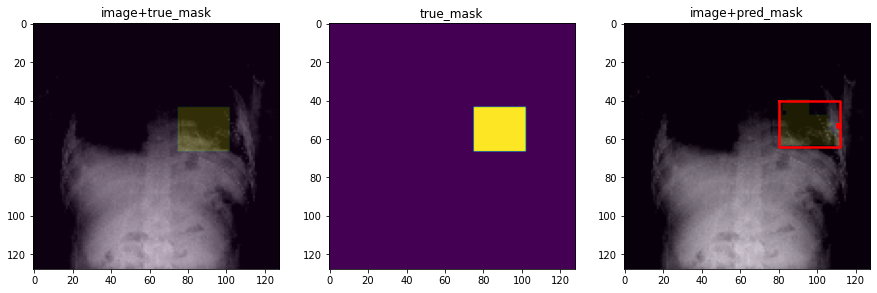

In [51]:
plot_sample(test_img, test_masks, test_pred, idx=5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


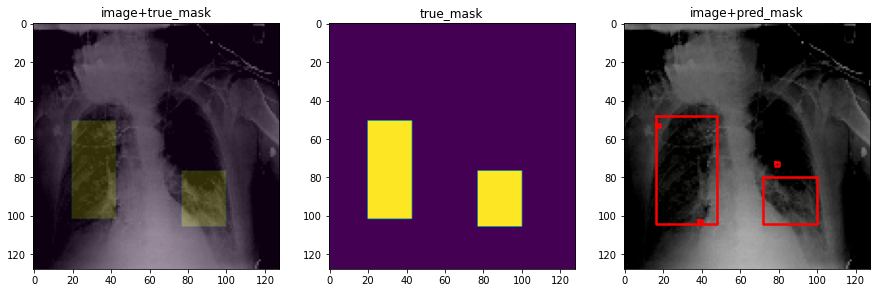

In [52]:
plot_sample(test_img, test_masks, test_pred, idx=16)

## Creating Submission File

In [53]:
test = [f for f in glob.glob('stage_2_test_images/*dcm')]
test[:5]

['stage_2_test_images/26aff776-ff9d-40f2-b899-6b88f1355506.dcm',
 'stage_2_test_images/26d3b1ef-f18b-46b8-8feb-9eb3fcd1abb1.dcm',
 'stage_2_test_images/26586d01-b992-41c4-a7a4-c9f1f8d102ad.dcm',
 'stage_2_test_images/26c07956-e243-4d83-82ea-b8da718b0e53.dcm',
 'stage_2_test_images/25ff4a6a-2ed1-48f6-9b00-448d559bccfe.dcm']

In [55]:
def predict_image(image_list):
    
    resize_factor = imageWidth / IMAGE_WIDTH
    columns = ['patientId','PredictionString', 'PredictTarget']
    df = pd.DataFrame(columns=columns)    
    
    for i, img in tqdm(enumerate(image_list)):
        
        ds = dicom.read_file(img)
        image = ds.pixel_array
        image = cv2.resize(image, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
        image = np.stack((image,)*3, axis=-1)            
        image = preprocess_input(np.array(image, dtype=np.float32))        
          
        patient_id = Path(img).stem
        
        output_string=""
        pred_mask = model.predict(image.reshape(1,128,128,3))
        pred_mask = pred_mask.reshape(128,128)
        pred_mask_t = pred_mask > 0.5
        label_img = label(pred_mask_t)
        regions = regionprops(label_img)
        
        MIN_AREA=100
        
        for props in regions:  
            minr, minc, maxr, maxc = props.bbox
            bx = (minc, maxc, maxc, minc, minc)
            by = (minr, minr, maxr, maxr, minr)
            
            if props.area > MIN_AREA:
                x = props.bbox[1]
                y = props.bbox[2]
                w = props.bbox[1]+props.bbox[3]
                h = props.bbox[0]+props.bbox[2]
                bboxes_str = "{} {} {} {}".format(x*resize_factor, y*resize_factor, \
                                                       w*resize_factor, h*resize_factor)
                output_string += bboxes_str
                
        output_string_len = len(output_string)
        target_out = 0
        if output_string_len>0:
            target_out = 1
        df.loc[i,'patientId'] = patient_id
        df.loc[i,'PredictionString'] = output_string
        df.loc[i,'PredictTarget'] = target_out
                
    return df              


In [56]:
## Creating the file dataframe using above function
out_file = predict_image(test)
submission_file = out_file[['patientId','PredictionString']]

## Export to CSV
submission_file.to_csv('MobileNet.csv')

3010it [32:25,  1.55it/s]
